In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SQLContext

In [3]:
#create session
appName = "Feature selection in Spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [14]:
from pyspark.sql import Row
from pyspark.sql.functions import *
#from pyspark.sql import HiveContext
import pyspark
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing
%matplotlib inline 

In [12]:
def generateData(n_clusters=3,
                 n_samples=20,
                 n_definingfeatures=2,
                 n_shuffle_defining_features=0,
                 n_uniform_features=0,
                 n_normal_features=0):
    data_x, data_y = make_blobs(n_samples=n_samples, centers=n_clusters, random_state=42, n_features=n_definingfeatures, 
                               cluster_std=0.05, center_box=(0, 1))

    n_non_shuffle_dims= np.arange(0,n_definingfeatures-n_shuffle_defining_features)

    non_shuffled_data = data_x[:, n_non_shuffle_dims ]
    shuffle_data = data_x[:, len(n_non_shuffle_dims): ]

    uniform_shuffle = np.random.uniform(low=0, high=1, size=(n_samples, n_shuffle_defining_features,))
    # shuffle the dimensions for each cluster
    dims = np.repeat(np.arange(n_shuffle_defining_features *2).reshape(1,-1),n_clusters, axis=0)
    
    for i in range(n_clusters):
        np.random.shuffle(dims[i])
    print(dims)
    cluster_shuffled_features = np.stack([dims[i] for i in data_y])
    mixed_data_to_shuffle =np.hstack([shuffle_data, uniform_shuffle])

    mixed_shuffled_data = np.zeros_like(mixed_data_to_shuffle)
    for i in range(len(mixed_data_to_shuffle)):
        mixed_shuffled_data[i] = mixed_data_to_shuffle[i, :][cluster_shuffled_features[i]]

    uniform_features = np.random.uniform(low=0.1, high=0.9, size=(n_samples, n_uniform_features,))
    normal_features = np.random.normal(size=(n_samples, n_normal_features,))


    data = np.concatenate([non_shuffled_data, mixed_shuffled_data, uniform_features,normal_features], axis=1)
    print(f'discriminative non_shuffled_data {non_shuffled_data.shape}, disc mixed_shuffled_data {mixed_shuffled_data.shape} ' +
         f'uniform_features {uniform_features.shape}, normal_features {normal_features.shape}')
    data = preprocessing.MinMaxScaler().fit_transform(data)
    return data, data_y

## Generate data having a combination of distributions


In [15]:
n_clusters = 4
n_samples=200
n_definingfeatures=5
n_shuffle_defining_features=3
n_uniform_features=1
n_normal_features=1
minClusterSize = 10 # parameter used for pruning the tree

data, truth = generateData(n_clusters=n_clusters,
                 n_samples=n_samples,
                 n_definingfeatures=n_definingfeatures,
                 n_shuffle_defining_features=n_shuffle_defining_features,
                 n_uniform_features=n_uniform_features,
                 n_normal_features=n_normal_features)
N, M = data.shape
print( data.shape)

[[2 1 4 3 0 5]
 [2 3 0 4 1 5]
 [2 3 1 4 0 5]
 [2 1 0 5 4 3]]
discriminative non_shuffled_data (200, 2), disc mixed_shuffled_data (200, 6) uniform_features (200, 1), normal_features (200, 1)
(200, 10)


## Filter low-variance features - Variance Threshold 

In [21]:
import sklearn.feature_selection
selector = sklearn.feature_selection.VarianceThreshold()
selector.fit_transform(data)[1].size #Tous les features sont maintenus car ils n'ont pas les même valeurs

10

## Mean absolute difference

In [22]:
mad = np.sum(np.abs(data -np.mean(data, axis =0 )), axis = 0)/data.shape[0]

<BarContainer object of 10 artists>

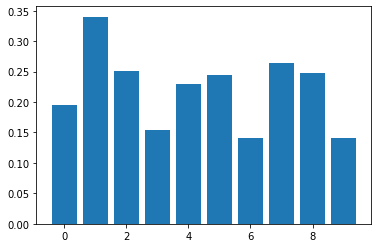

In [23]:
plt.bar(np.arange(data.shape[1]),mad)

## Dispesion ratio


In [24]:
def dispersion(data):
    data = data +1 #avoid 0 division
    aritmeticMean = np.mean(data, axis =0 )
    geometricMean = np.power(np.prod(data, axis =0 ),1/data.shape[0])
    R = aritmeticMean/geometricMean
    return R
R = dispersion(data)

<BarContainer object of 10 artists>

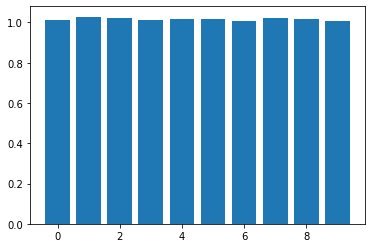

In [25]:
plt.bar(np.arange(data.shape[1]),R)

## Laplacian Score


In [29]:

def construct_W(X, neighbour_size = 5, t = 1):
    n_samples, n_features = np.shape(X)
    S=kneighbors_graph(X, neighbour_size+1, mode='distance',metric='euclidean') #sqecludian distance works only with mode=connectivity  results were absurd
    S = (-1*(S*S))/(2*t*t)
    S=S.tocsc()
    S=expm(S) # exponential
    S=S.tocsr()
    #[1]  M. Belkin and P. Niyogi, “Laplacian Eigenmaps and Spectral Techniques for Embedding and Clustering,” Advances in Neural Information Processing Systems,
    #Vol. 14, 2001. Following the paper to make the weights matrix symmetrix we use this method
    bigger = np.transpose(S) > S
    S = S - S.multiply(bigger) + np.transpose(S).multiply(bigger)
    return S

def LaplacianScore(X, neighbour_size = 5,  t = 1):
    W = construct_W(X,t=t,neighbour_size=neighbour_size)
    n_samples, n_features = np.shape(X)
    
    #construct the diagonal matrix
    D=np.array(W.sum(axis=1))
    D = scipy.sparse.diags(np.transpose(D), [0])
    #construct graph Laplacian L
    L=D-W.toarray()

    #construct 1= [1,···,1]' 
    I=np.ones((n_samples,n_features))

    #construct fr' => fr= [fr1,...,frn]'
    Xt = np.transpose(X)

    #construct fr^=fr-(frt D I/It D I)I
    t=np.matmul(np.matmul(Xt,D.toarray()),I)/np.matmul(np.matmul(np.transpose(I),D.toarray()),I)
    t=t[:,0]
    t=np.tile(t,(n_samples,1))
    fr=X-t

    #Compute Laplacian Score
    fr_t=np.transpose(fr)
    Lr=np.matmul(np.matmul(fr_t,L),fr)/np.matmul(np.dot(fr_t,D.toarray()),fr)

    return np.diag(Lr)

In [32]:
from sklearn.neighbors import kneighbors_graph 
import scipy
import scipy.sparse 
from scipy.sparse.linalg import expm
import scipy.spatial.distance
ls =LaplacianScore(data)

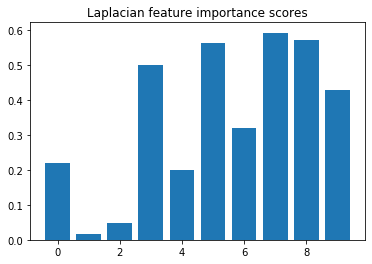

In [33]:
plt.title('Laplacian feature importance scores')
plt.bar(np.arange(data.shape[1]),ls);

## Laplacian Score combined with distance-based entropy 

In [34]:
def distanceEntropy(d, mu = 0.5, beta=10):
    """
    As per: An Unsupervised Feature Selection Algorithm: Laplacian Score Combined with
    Distance-based Entropy Measure, Rongye Liu 
    """
    if d<=mu:
        result = (np.exp(beta * d) - np.exp(0))/(np.exp(beta * mu) - np.exp(0))
    else:
        result = (np.exp(beta * (1-d) )- np.exp(0))/(np.exp(beta *(1- mu)) - np.exp(0))              
    return result

In [35]:
def lse(data, ls):
    """
    This method takes as input a dataset, its laplacian scores for all features
    and applies distance based entropy feature selection in order to identify
    the best subset of features in the laplacian sense.
    """
    orderedFeatures = np.argsort(ls)
    scores = {}
    for i in range (2,len(ls)):
        selectedFeatures = orderedFeatures[:i]
        selectedFeaturesDataset = data[:, selectedFeatures]
        d =sklearn.metrics.pairwise_distances(selectedFeaturesDataset, metric = 'euclidean' )
        beta =10
        mu = 0.5

        d = preprocessing.MinMaxScaler().fit_transform(d)
        e = np.vectorize(distanceEntropy)(d) 
        e = preprocessing.MinMaxScaler().fit_transform(e)
        totalEntropy= np.sum(e)
        scores[i] = totalEntropy
    bestFeatures = orderedFeatures[:list(scores.keys())[np.argmin(scores.values())]]
    return bestFeatures

## Multi-Cluster Feature selection MCFS

In [36]:
import numpy as np
from scipy.sparse import *
from sklearn.metrics.pairwise import pairwise_distances


def construct_W(X, **kwargs):
    """
    Construct the affinity matrix W through different ways
    Notes
    -----
    if kwargs is null, use the default parameter settings;
    if kwargs is not null, construct the affinity matrix according to parameters in kwargs
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        parameters to construct different affinity matrix W:
        y: {numpy array}, shape (n_samples, 1)
            the true label information needed under the 'supervised' neighbor mode
        metric: {string}
            choices for different distance measures
            'euclidean' - use euclidean distance
            'cosine' - use cosine distance (default)
        neighbor_mode: {string}
            indicates how to construct the graph
            'knn' - put an edge between two nodes if and only if they are among the
                    k nearest neighbors of each other (default)
            'supervised' - put an edge between two nodes if they belong to same class
                    and they are among the k nearest neighbors of each other
        weight_mode: {string}
            indicates how to assign weights for each edge in the graph
            'binary' - 0-1 weighting, every edge receives weight of 1 (default)
            'heat_kernel' - if nodes i and j are connected, put weight W_ij = exp(-norm(x_i - x_j)/2t^2)
                            this weight mode can only be used under 'euclidean' metric and you are required
                            to provide the parameter t
            'cosine' - if nodes i and j are connected, put weight cosine(x_i,x_j).
                        this weight mode can only be used under 'cosine' metric
        k: {int}
            choices for the number of neighbors (default k = 5)
        t: {float}
            parameter for the 'heat_kernel' weight_mode
        fisher_score: {boolean}
            indicates whether to build the affinity matrix in a fisher score way, in which W_ij = 1/n_l if yi = yj = l;
            otherwise W_ij = 0 (default fisher_score = false)
        reliefF: {boolean}
            indicates whether to build the affinity matrix in a reliefF way, NH(x) and NM(x,y) denotes a set of
            k nearest points to x with the same class as x, and a different class (the class y), respectively.
            W_ij = 1 if i = j; W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y) (default reliefF = false)
    Output
    ------
    W: {sparse matrix}, shape (n_samples, n_samples)
        output affinity matrix W
    """

    # default metric is 'cosine'
    if 'metric' not in kwargs.keys():
        kwargs['metric'] = 'cosine'

    # default neighbor mode is 'knn' and default neighbor size is 5
    if 'neighbor_mode' not in kwargs.keys():
        kwargs['neighbor_mode'] = 'knn'
    if kwargs['neighbor_mode'] == 'knn' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'y' not in kwargs.keys():
        print ('Warning: label is required in the supervised neighborMode!!!')
        exit(0)

    # default weight mode is 'binary', default t in heat kernel mode is 1
    if 'weight_mode' not in kwargs.keys():
        kwargs['weight_mode'] = 'binary'
    if kwargs['weight_mode'] == 'heat_kernel':
        if kwargs['metric'] != 'euclidean':
            kwargs['metric'] = 'euclidean'
        if 't' not in kwargs.keys():
            kwargs['t'] = 1
    elif kwargs['weight_mode'] == 'cosine':
        if kwargs['metric'] != 'cosine':
            kwargs['metric'] = 'cosine'

    # default fisher_score and reliefF mode are 'false'
    if 'fisher_score' not in kwargs.keys():
        kwargs['fisher_score'] = False
    if 'reliefF' not in kwargs.keys():
        kwargs['reliefF'] = False

    n_samples, n_features = np.shape(X)

    # choose 'knn' neighbor mode
    if kwargs['neighbor_mode'] == 'knn':
        k = kwargs['k']
        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                # compute pairwise euclidean distances
                D = pairwise_distances(X)
                D **= 2
                # sort the distance matrix D in ascending order
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                # choose the k-nearest neighbors for each instance
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            elif kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                # compute pairwise cosine distances
                D_cosine = np.dot(X, np.transpose(X))
                # sort the distance matrix D in descending order
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            t = kwargs['t']
            # compute pairwise euclidean distances
            D = pairwise_distances(X)
            D **= 2
            # sort the distance matrix D in ascending order
            dump = np.sort(D, axis=1)
            idx = np.argsort(D, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = dump[:, 0:k+1]
            # compute the pairwise heat kernel distances
            dump_heat_kernel = np.exp(-dump_new/(2*t*t))
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_heat_kernel, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            # compute pairwise cosine distances
            D_cosine = np.dot(X, np.transpose(X))
            # sort the distance matrix D in ascending order
            dump = np.sort(-D_cosine, axis=1)
            idx = np.argsort(-D_cosine, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = -dump[:, 0:k+1]
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_new, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

    # choose supervised neighborMode
    elif kwargs['neighbor_mode'] == 'supervised':
        k = kwargs['k']
        # get true labels and the number of classes
        y = kwargs['y']
        label = np.unique(y)
        n_classes = np.unique(y).size
        # construct the weight matrix W in a fisherScore way, W_ij = 1/n_l if yi = yj = l, otherwise W_ij = 0
        if kwargs['fisher_score'] is True:
            W = lil_matrix((n_samples, n_samples))
            for i in range(n_classes):
                class_idx = (y == label[i])
                class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
                W[class_idx_all] = 1.0/np.sum(np.sum(class_idx))
            return W

        # construct the weight matrix W in a reliefF way, NH(x) and NM(x,y) denotes a set of k nearest
        # points to x with the same class as x, a different class (the class y), respectively. W_ij = 1 if i = j;
        # W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y)
        if kwargs['reliefF'] is True:
            # when xj in NH(xi)
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                n_smp_class = (class_idx[idx_new[:]]).size
                if len(class_idx) <= k:
                    k = len(class_idx) - 1
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = 1.0/k
                id_now += n_smp_class
            W1 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            # when i = j, W_ij = 1
            for i in range(n_samples):
                W1[i, i] = 1
            # when x_j in NM(x_i, y)
            G = np.zeros((n_samples*k*(n_classes - 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx1 = np.column_stack(np.where(y == label[i]))[:, 0]
                X1 = X[class_idx1, :]
                for j in range(n_classes):
                    if label[j] != label[i]:
                        class_idx2 = np.column_stack(np.where(y == label[j]))[:, 0]
                        X2 = X[class_idx2, :]
                        D = pairwise_distances(X1, X2)
                        idx = np.argsort(D, axis=1)
                        idx_new = idx[:, 0:k]
                        n_smp_class = len(class_idx1)*k
                        G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx1, (k, 1)).reshape(-1)
                        G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx2[idx_new[:]], order='F')
                        G[id_now:n_smp_class+id_now, 2] = -1.0/((n_classes-1)*k)
                        id_now += n_smp_class
            W2 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W2) > W2
            W2 = W2 - W2.multiply(bigger) + np.transpose(W2).multiply(bigger)
            W = W1 + W2
            return W

        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise euclidean distances for instances in class i
                    D = pairwise_distances(X[class_idx, :])
                    D **= 2
                    # sort the distance matrix D in ascending order for instances in class i
                    idx = np.argsort(D, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            if kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise cosine distances for instances in class i
                    D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                    # sort the distance matrix D in descending order for instances in class i
                    idx = np.argsort(-D_cosine, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                # sort the distance matrix D in ascending order for instances in class i
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = dump[:, 0:k+1]
                t = kwargs['t']
                # compute pairwise heat kernel distances for instances in class i
                dump_heat_kernel = np.exp(-dump_new/(2*t*t))
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_heat_kernel, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                # sort the distance matrix D in descending order for instances in class i
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = -dump[:, 0:k+1]
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_new, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

In [37]:
import scipy
import numpy as np
from sklearn import linear_model

def mcfs(X, n_selected_features, **kwargs):
    """
    This function implements unsupervised feature selection for multi-cluster data.
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    n_selected_features: {int}
        number of features to select
    kwargs: {dictionary}
        W: {sparse matrix}, shape (n_samples, n_samples)
            affinity matrix
        n_clusters: {int}
            number of clusters (default is 5)
    Output
    ------
    W: {numpy array}, shape(n_features, n_clusters)
        feature weight matrix
    Reference
    ---------
    Cai, Deng et al. "Unsupervised Feature Selection for Multi-Cluster Data." KDD 2010.
    """

    # use the default affinity matrix
    if 'W' not in kwargs:
        W = construct_W(X)
    else:
        W = kwargs['W']
    # default number of clusters is 5
    if 'n_clusters' not in kwargs:
        n_clusters = 5
    else:
        n_clusters = kwargs['n_clusters']

    # solve the generalized eigen-decomposition problem and get the top K
    # eigen-vectors with respect to the smallest eigenvalues
    W = W.toarray()
    W = (W + W.T) / 2
    W_norm = np.diag(np.sqrt(1 / W.sum(1)))
    W = np.dot(W_norm, np.dot(W, W_norm))
    WT = W.T
    W[W < WT] = WT[W < WT]
    eigen_value, ul = scipy.linalg.eigh(a=W)
    Y = np.dot(W_norm, ul[:, -1*n_clusters-1:-1])

    # solve K L1-regularized regression problem using LARs algorithm with cardinality constraint being d
    n_sample, n_feature = X.shape
    W = np.zeros((n_feature, n_clusters))
    for i in range(n_clusters):
        clf = linear_model.Lars(n_nonzero_coefs=n_selected_features)
        clf.fit(X, Y[:, i])
        W[:, i] = clf.coef_
    return W


## Spectral Feature Selection SPEC

In [38]:
from abc import abstractmethod

import numpy as np
from sklearn.exceptions import NotFittedError


class ScoreSelectorMixin:
    """
    Mixin that adds getter for calculation of scores of features and checks that scores are calculated
    """

    @abstractmethod
    def _get_scores(self):
        """
        Get calculated scores for features
        Returns
        ------
        scores: ndarray
            Numpy Array with length equal to the initial number of features in dataset. Every element
            of the array is the score of this feature
        """
        pass

    def _check_scores_set(self):
        """
        Checks that scores for features are computed
        Returns
        -------
        check: bool
            Flag that indicates that scores are computed
        """

        return self._get_scores() is not None


class ThresholdSelectorMixin(ScoreSelectorMixin):
    """
    Mixin that selects features according to some threshold. That means that
    all features whose score is higher than threshold are selected
    """

    @abstractmethod
    def _get_threshold(self):
        """
        Get the value of threshold
        Returns
        -------
        threshold: float
            The value of threshold
        """
        pass

    def _get_support_mask(self):
        if not self._check_scores_set():
            raise NotFittedError('Feature Selector is not fitted')
        return self._get_scores() > self._get_threshold()


class KBestSelectorMixin(ScoreSelectorMixin):
    """
    Mixin that selects K best features according to their scores
    """

    @abstractmethod
    def _get_k(self):
        """
        Get number of features to select
        Returns
        -------
        k: int
            Number of features to select
        """
        pass

    def _get_support_mask(self):
        if not self._check_scores_set():
            raise NotFittedError('Feature Selector is not fitted')
        mask = np.zeros(self._get_scores().shape, dtype=bool)
        mask[np.argsort(self._get_scores(), kind="mergesort")[-self._get_k():]] = 1
        return mask
from abc import abstractmethod

from sklearn.base import BaseEstimator
from sklearn.feature_selection.base import SelectorMixin
from sklearn.base import ClusterMixin


class BaseFeatureSelector(BaseEstimator, SelectorMixin):
    """
    Base class for all feature selection algorithms. It's SKLearn-compliant, so it can be used in pipelines.
    Successors should override methods :meth:`fit`  and :meth:`_get_support_mask`.
    """

    @abstractmethod
    def fit(self, x, *rest):
        """
        Fit selector to a dataset.
        Parameters
        ----------
        x: ndarray
            The input samples - array of shape [n_samples, n_features].
        rest: list
            List of miscellaneous arguments.
        Returns
        -------
        selector: BaseFeatureSelector
            Returns self to support chaining.
        """

        return self


class KBestFeatureSelector(KBestSelectorMixin, BaseFeatureSelector):
    """
    Base class for algorithms that selects K best features according to features scores.
    Successors should override method :meth:`_calc_scores` for computation of the score.
    Parameters
    ----------
    k: int
        Number of features to select
    """

    def __init__(self, k):
        self.k = k
        self.scores = None

    @abstractmethod
    def _calc_scores(self, x):
        """
        Calculate scores for features in dataset.
        Parameters
        ----------
        x: ndarray
            The input samples - array of shape [n_samples, n_features].
        Returns
        -------
        scores: ndarray
            Array of shape [n_features]. i-th element is a score of i-th feature.
        """
        pass

    def fit(self, x, *rest):
        self.scores = self._calc_scores(x)
        return self

    def _get_k(self):
        return self.k

    def _get_scores(self):
        return self.scores


class ClusteringFeatureSelector(KBestSelectorMixin, BaseFeatureSelector, ClusterMixin):
    """
    Clusters samples and simultaneously finds relevant features. Allows to transform dataset
    and select K best features according to features scores.
    Parameters
    ----------
    k: int
        Number of features to select
    """

    def __init__(self, k):
        self.k = k
        self.scores = None
        self.labels_ = None

    @abstractmethod
    def _calc_scores_and_labels(self, x):
        """
        Calculate scores and labels for samples.
        Parameters
        ----------
        x: ndarray
            The input samples - array of shape [n_samples, n_features].
        Returns
        -------
        scores_and_labels: tuple
            Tuple where first element is scores of features and second element are cluster labels for samples
        """
        pass

    def fit(self, x, *rest):
        scores, labels = self._calc_scores_and_labels(x)
        self.scores = scores
        self.labels_ = labels
        return self

    def _get_scores(self):
        return self.scores

    def _get_k(self):
        return self.k

In [39]:
from abc import abstractmethod

import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity



class SPEC(KBestFeatureSelector):
    """
    SPEC-family of feature selection algorithms.

    Every algorithm of this family creates graph representation of distribution of samples in a high-dimensional space.
    Samples becomes vertices and RBF-distance between them becomes weight of the edge. Algorithms use Spectral Graph
    Theory to calculate features scores.

    Based on the article `"Spectral feature selection for supervised and unsupervised learning." <http://www.public.asu.edu/~huanliu/papers/icml07.pdf>`_.
    """

    @abstractmethod
    def _calc_spec_scores(self, degree, laplacian, normalised_features, normaliser):
        """
        Calculate SPEC scores for the method

        Parameters
        ----------
        degree: ndarray
            Degree matrix of the graph
        laplacian: ndarray
            Laplacian of the graph
        normalised_features: ndarray
            Feature vectors, normalised by normaliser
        normaliser: ndarray
            Vector computed by the degree matrix and used for normalisation of feature vectors and laplacian

        Returns
        -------
        scores: ndarray
            Scores of features
        """
        pass

    def _calc_scores(self, x):
        similarity = rbf_kernel(x)
        adjacency = similarity
        degree_vector = np.sum(adjacency, 1)
        degree = np.diag(degree_vector)
        laplacian = degree - adjacency
        normaliser_vector = np.reciprocal(np.sqrt(degree_vector))
        normaliser = np.diag(normaliser_vector)

        normalised_laplacian = normaliser.dot(laplacian).dot(normaliser)

        weighted_features = np.matmul(normaliser, x)

        normalised_features = weighted_features / np.linalg.norm(weighted_features, axis=0)
        return self._calc_spec_scores(degree, normalised_laplacian, normalised_features, normaliser)



class NormalizedCut(SPEC):
    """
    Feature selection algorithm that represents samples as vertices of graph.
    Weights of edges of this graph are equal to RBF-distances between points.
    Algorithm attempts to find minimal cut in this graph.

    Algorithm selects k features which were `separated` by this cut as they are considered to be better for explanation
    of the dataset.

    Parameters
    ----------
    k: int
        Number of features to select
    """

    def _calc_spec_scores(self, degree, laplacian, normalised_features, normaliser):
        all_to_all = normalised_features.transpose().dot(laplacian).dot(normalised_features)
        return np.diag(all_to_all)



class GenericSPEC(NormalizedCut):
    """
    Feature selection algorithm that represents samples as vertices of graph.
    Weights of edges of this graph are equal to RBF-distances between points.

    Algorithm uses Spectral Graph Theory to find features with the best separability.

    To do this, algorithm finds the trivial eugenvector of the Laplacian of the graph and uses it to
    normalise scores computed using :class:`NormalizedCut`. Such normalisation helps to improve
    accuracy of feature selection according to the article SPEC family is based on.

    Algorithm selects top k features according to this scores

    Parameters
    ----------
    k: int
        Number of features to select
    """

    def _calc_spec_scores(self, degree, laplacian, normalised_features, normaliser):
        normalised_cut = super()._calc_spec_scores(
            degree, laplacian, normalised_features, normaliser
        )
        trivial_eugenvector = normaliser.dot(np.ones([normalised_features.shape[0], 1]))
        norm = 1 - normalised_features.transpose().dot(trivial_eugenvector).squeeze().transpose()

        return normalised_cut / norm



class FixedSPEC(SPEC):
    """
    Feature selection algorithm that represents samples as vertices of graph.
    Weights of edges of this graph are equal to RBF-distances between points.

    Algorithm uses Spectral Graph Theory to find features with the best separability in assumption that
    points are separated to the predefined number of clusters

    To do this, algorithm finds eigenvectors corresponding to K smallest eigenvalues of the Laplacian of the graph,
    except the trivial one, and uses cosine distance between them and feature vectors to detect the most explaining
    features. Algorithm selects k features using this score.

    Parameters
    ----------
    k: int
        Number of features to select
    clusters: int
        Expected number of clusters
    """
    def __init__(self, k, clusters):
        super().__init__(k)
        self.clusters = clusters

    def _calc_spec_scores(self, degree, laplacian, normalised_features, normaliser):
        values, vectors = np.linalg.eigh(laplacian)

        result = np.zeros([normalised_features.shape[1]])
        for k in range(1, self.clusters):
            eigenvalue = values[k]
            eigenvector = vectors[:, k]
            cosines = np.zeros_like(result)
            for i in range(normalised_features.shape[1]):
                feature = normalised_features[:, i]
                similarity = cosine_similarity([eigenvector], [feature])[0]
                cosines[i] = similarity * similarity
            result += (2 - eigenvalue) * cosines
        return -result